In [1]:
!pip -qq install bertopic

In [2]:
import pandas as pd
from bertopic import BERTopic

In [3]:
art_df = pd.read_csv("cognit_paper_unique_polarity.csv" , header = 0)
#Removing pre index row
art_df.drop(art_df.columns[0], axis = 1, inplace = True)
art_df.columns = ["title", "author", "university", "link","body","polarity",]
art_df

,title,author,university,link,body,polarity
0,Addressing the challenges of client retention ...,David Burnes,University of Toronto,https://cognit.ca/en/research/project/109991,Elder abuse is a pervasive form of inter-perso...,0.088414
1,What Does Engagement Look Like with Victims of...,David Burnes,University of Toronto,https://cognit.ca/en/research/project/226573,No summary,0.000000
2,"""linkAGEs - Aging in Intergenerational Societi...",Lynn McDonald,University of Toronto,https://cognit.ca/en/research/project/225173,No summary,0.000000
3,The potential for elders' cultural knowledge t...,George Sefa Dei,University of Toronto,https://cognit.ca/en/research/project/113011,Black youth in Canada face significant dispari...,0.104545
4,Supporting the creation of a LEARNing INteGrat...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/153228,Elderly patients do not always receive the bes...,0.409375
...,...,...,...,...,...,...
138,Restor(y)ing place-based Indigenous physical c...,Moss E Norman,University of British Columbia,https://cognit.ca/en/research/project/113521,This project engages two Swampy Cree (Muskéko ...,0.082702
139,Wholistic Indigenous Health and Wellness throu...,Moss E Norman,University of British Columbia,https://cognit.ca/en/research/project/216287,Our primary objective is to assemble a disting...,0.107071
140,ATSA-ESI: Assistive Technology Supporting Agin...,Jesse Hoey,University of Waterloo,https://cognit.ca/en/research/project/9941,For the past twelve years I have been building...,0.112954
141,The Women and HIV Research Program: Impactful ...,Mona R Loutfy,Women's College Hospital,https://cognit.ca/en/research/project/147849,Dr. Mona Loutfy is recognized as a national an...,0.142929


In [4]:
#Removing articles with no body text
art_df = art_df[art_df.body != "No summary"]
#Removing duplicated news based on header and body text combination
art_df = art_df.drop_duplicates(subset=['polarity'], keep=False)
art_df.reset_index(drop=True, inplace = True)

In [5]:
import nltk
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('wordnet')

stemmer = SnowballStemmer('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
porter = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [7]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [8]:
df_lemma ={}
df_lemma['lemmatized'] = []
for i in art_df['body']:
  lemma = ' '.join(preprocess(i))
  df_lemma['lemmatized'].append(lemma)

In [9]:
art_df['lemmatized'] = df_lemma['lemmatized']

In [10]:
# Instanciating BERTopic
topic_model = BERTopic(language = "english", calculate_probabilities = True, verbose = True)

In [11]:
# Fitting
topics, probs = topic_model.fit_transform(art_df['lemmatized'])

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2022-03-19 22:44:01,903 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-03-19 22:44:14,225 - BERTopic - Reduced dimensionality with UMAP
2022-03-19 22:44:14,245 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [12]:
topic_model.save("BERTopic_elderly_art_model")

In [13]:
topic_model = BERTopic.load("BERTopic_elderly_art_model")

In [14]:
topic_model.get_topic_info().head(20)

,Topic,Count,Name
0,-1,49,-1_indigen_communiti_research_health
1,0,28,0_communiti_research_indigen_elder
2,1,24,1_care_patient_hospit_studi


In [15]:
print(f"Topics discovered: {max(topic_model.get_topic_info()['Topic']) +1}")

Topics discovered: 2


In [16]:
art_df['topic'] = topics
art_df.head()

,title,author,university,link,body,polarity,lemmatized,topic
0,Addressing the challenges of client retention ...,David Burnes,University of Toronto,https://cognit.ca/en/research/project/109991,Elder abuse is a pervasive form of inter-perso...,0.088414,elder abus pervas form inter person violenc ca...,0
1,The potential for elders' cultural knowledge t...,George Sefa Dei,University of Toronto,https://cognit.ca/en/research/project/113011,Black youth in Canada face significant dispari...,0.104545,black youth canada face signific dispar educ s...,0
2,Supporting the creation of a LEARNing INteGrat...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/153228,Elderly patients do not always receive the bes...,0.409375,elder patient receiv best care help return hom...,1
3,Supporting the creation of a LEARNing INteGrat...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/153897,Elderly patients discharged from emergency dep...,0.237500,elder patient discharg emerg depart repeat rea...,1
4,The Canadian Network of COVID-19 Clinical Tria...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/232693,"Nearly 350,000 Canadians have been diagnosed w...",0.229924,near canadian diagnos covid infect canada elde...,-1


In [17]:
art_df.to_csv('topic_elderly_articles.csv')

In [18]:
topic_model.visualize_barchart(top_n_topics=16)

In [19]:
topic_model.visualize_term_rank()

In [20]:
topic_model.get_topic(2)

False

In [21]:
covid_topics, covid_topics_similarity = topic_model.find_topics("covid", top_n=8)
covid_topics, covid_topics_similarity

([1, 0, -1], [0.4849139982707712, 0.4180574514429676, 0.3973658228199328])

In [22]:
health_topics, health_topics_similarity = topic_model.find_topics("health", top_n=4)
health_topics, health_topics_similarity

([1, -1, 0], [0.5727169928591349, 0.5633738357677589, 0.556577353691488])

In [23]:
house_topics, house_topics_similarity = topic_model.find_topics("house", top_n=6)
house_topics, house_topics_similarity

([1, 0, -1], [0.51598845931979, 0.42517072561480146, 0.41243256553387336])

In [24]:
homecare_topics, homecare_topics_similarity = topic_model.find_topics("homecare", top_n=3)
homecare_topics, homecare_topics_similarity

([1, 0, -1], [0.44213178355956245, 0.36323926922637173, 0.34242777538395947])

In [25]:
money_topics, money_topics_similarity = topic_model.find_topics("money", top_n=3)
money_topics, money_topics_similarity

([1, 0, -1], [0.5043318813613653, 0.44667559542908397, 0.43080745867562])

In [26]:
charity_topics, charity_topics_similarity = topic_model.find_topics("charity", top_n=3)
charity_topics, charity_topics_similarity

([1, 0, -1], [0.4967844039937608, 0.4377235699305154, 0.41876540107275717])

In [27]:
safety_topics, safety_topics_similarity = topic_model.find_topics("safety", top_n=3)
safety_topics, safety_topics_similarity

([1, -1, 0], [0.4323693861323749, 0.40605540583825395, 0.3962346827076736])

In [28]:
activity_topics, activity_topics_similarity = topic_model.find_topics("activity", top_n=10)
activity_topics, activity_topics_similarity

([-1, 0, 1], [0.5342175434522486, 0.5113490571754107, 0.42698350223760484])

In [29]:
first_nations_topics, first_nations_topics_similarity = topic_model.find_topics("first nations", top_n=8)
first_nations_topics, first_nations_topics_similarity

([0, -1, 1], [0.2889421163148289, 0.2861545818610855, 0.26078324451475743])

In [30]:
first_nations_topics, first_nations_topics_similarity = topic_model.find_topics("inter generation", top_n=8)
first_nations_topics, first_nations_topics_similarity

([-1, 0, 1], [0.4541878496661423, 0.4417010934366956, 0.3466739210052452])

In [31]:
categories = ['covid', 'health', 'house', 'homecare', 'money', 'volunteer',
              'safety', 'abuse', 'physical activity', 'social activity',
              'first nations', 'schooling', 'environment', 'autonomy',
              'freedom', 'climate', 'temperature', 'vaccine', 'grocery']

similarity_cutoff = 0.50
top_n = 20

my_topics = {}
for category in categories:
  # Initiate category list
  my_topics[str(category)] = []

  # Get topics and similarities for given category
  topics, similarities = topic_model.find_topics(category, top_n = top_n)

  # Populate my_topics dict
  for topic, similarity in zip(topics, similarities):
    if similarity >= similarity_cutoff:
      my_topics[str(category)].append(topic)

In [32]:
for key, value in zip(my_topics.keys(), my_topics.values()):
  print(key, value)

covid []
health [1, -1, 0]
house [1]
homecare []
money [1]
volunteer [1]
safety []
abuse [1]
physical activity []
social activity []
first nations []
schooling []
environment [-1, 0]
autonomy []
freedom []
climate []
temperature []
vaccine []
grocery []


In [33]:
topic_model.get_topics()

{-1: [('indigen', 0.04815706673361289),
  ('communiti', 0.046276581362960784),
  ('research', 0.04208218361002045),
  ('health', 0.03296584883562139),
  ('languag', 0.032161774112043906),
  ('elder', 0.028649771599895933),
  ('knowledg', 0.02746646014418157),
  ('develop', 0.026844669276152842),
  ('peopl', 0.026018362684468718),
  ('need', 0.024008084900539815)],
 0: [('communiti', 0.08559732626425048),
  ('research', 0.06464594168077908),
  ('indigen', 0.060336727687889675),
  ('elder', 0.04513979137433622),
  ('knowledg', 0.042805013657064114),
  ('cultur', 0.04157010603005189),
  ('health', 0.03983045755206047),
  ('age', 0.035073839605457395),
  ('well', 0.029955726223130554),
  ('develop', 0.029818483903840648)],
 1: [('care', 0.11443096680606475),
  ('patient', 0.0876763471728824),
  ('hospit', 0.0514105337336219),
  ('studi', 0.044705156023642),
  ('long', 0.039536673746943654),
  ('term', 0.039353058583586675),
  ('elder', 0.03783604547619882),
  ('canadian', 0.037165046787695

In [34]:
# Assigning topics
for i, topic in enumerate(art_df['topic']):
  art_df.loc[i, 'topics'] = ''
  temp_topics = []
  for key, value in zip(my_topics.keys(), my_topics.values()):
    if topic in value:
      temp_topics.append(key)
    art_df.loc[i, 'topics'] = ', '.join(temp_topics)

In [35]:
art_df

,title,author,university,link,body,polarity,lemmatized,topic,topics
0,Addressing the challenges of client retention ...,David Burnes,University of Toronto,https://cognit.ca/en/research/project/109991,Elder abuse is a pervasive form of inter-perso...,0.088414,elder abus pervas form inter person violenc ca...,0,"health, environment"
1,The potential for elders' cultural knowledge t...,George Sefa Dei,University of Toronto,https://cognit.ca/en/research/project/113011,Black youth in Canada face significant dispari...,0.104545,black youth canada face signific dispar educ s...,0,"health, environment"
2,Supporting the creation of a LEARNing INteGrat...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/153228,Elderly patients do not always receive the bes...,0.409375,elder patient receiv best care help return hom...,1,"health, house, money, volunteer, abuse"
3,Supporting the creation of a LEARNing INteGrat...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/153897,Elderly patients discharged from emergency dep...,0.237500,elder patient discharg emerg depart repeat rea...,1,"health, house, money, volunteer, abuse"
4,The Canadian Network of COVID-19 Clinical Tria...,Patrick Archambault,Laval University,https://cognit.ca/en/research/project/232693,"Nearly 350,000 Canadians have been diagnosed w...",0.229924,near canadian diagnos covid infect canada elde...,-1,"health, environment"
...,...,...,...,...,...,...,...,...,...
96,Restor(y)ing place-based Indigenous physical c...,Moss E Norman,University of British Columbia,https://cognit.ca/en/research/project/113521,This project engages two Swampy Cree (Muskéko ...,0.082702,project engag swampi cree muskéko ininiw natio...,0,"health, environment"
97,Wholistic Indigenous Health and Wellness throu...,Moss E Norman,University of British Columbia,https://cognit.ca/en/research/project/216287,Our primary objective is to assemble a disting...,0.107071,primari object assembl distinguish group indig...,0,"health, environment"
98,ATSA-ESI: Assistive Technology Supporting Agin...,Jesse Hoey,University of Waterloo,https://cognit.ca/en/research/project/9941,For the past twelve years I have been building...,0.112954,past year build sophist assist technolog desig...,-1,"health, environment"
99,The Women and HIV Research Program: Impactful ...,Mona R Loutfy,Women's College Hospital,https://cognit.ca/en/research/project/147849,Dr. Mona Loutfy is recognized as a national an...,0.142929,mona loutfi recogn nation intern leader area w...,-1,"health, environment"


In [36]:
art_df.to_csv('topic_elderly_articles.csv')

In [37]:
!pip -qq install wordcloud

<function matplotlib.pyplot.show>

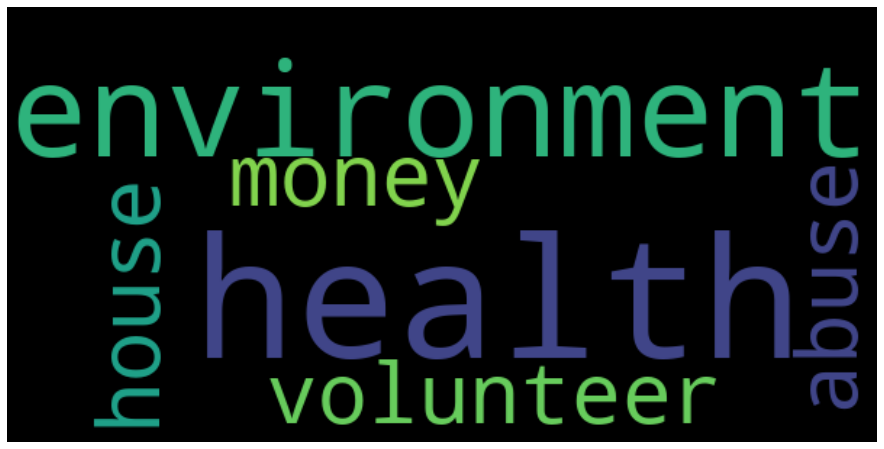

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color = 'black',
               collocations = False,
               width = 600,
               height = 300).generate(', '.join(art_df['topics'].tolist()))

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show